In [8]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from tabulate import tabulate

from sklearn.metrics import accuracy_score, f1_score, brier_score_loss, log_loss

from models import get_rain_nn, calibrate_rain_nn
from calibration import expected_calibration_error, max_calibration_error, overconfidence_error, inverse_probability_weighting

sns.set(rc={'figure.figsize':(15,5)})

Read validation and test dataset

In [9]:
# read the validation data
validation_df = pd.read_csv("datasets/cleaned_weatherAUS_validation.csv")
X_validation = validation_df.drop(["RainTomorrow"], axis=1)
y_validation = validation_df["RainTomorrow"]

# read the test data
test_df = pd.read_csv("datasets/cleaned_weatherAUS_test.csv")
X_test = test_df.drop(["RainTomorrow"], axis=1)
y_test = test_df["RainTomorrow"]

Create neural network models

In [10]:
# create a dictionary of models
rain_nn = get_rain_nn()
rain_nn_ps = calibrate_rain_nn(rain_nn, "ps")
rain_nn_bc = calibrate_rain_nn(rain_nn, "bc")
rain_nn_ir = calibrate_rain_nn(rain_nn, "ir")
models = {"nn": rain_nn, "nn_ir": rain_nn_ir, "nn_ps": rain_nn_ps, "nn_ops": rain_nn_bc}

Get models predictions

In [11]:
# save models predictions to a dictionary
models_preds = {}
for model_name, model in models.items():
    if model_name == "nn_ops":
        models_preds[model_name] = model.predict_proba(X_test)
    else:
        models_preds[model_name] = model.predict_proba(X_test)[:, 1]

models_preds['nn_ir_pt'] = inverse_probability_weighting(models_preds["nn_ir"])
models_preds['nn_pt'] = inverse_probability_weighting(models_preds["nn"])

Plot reliability diagram of every nn model

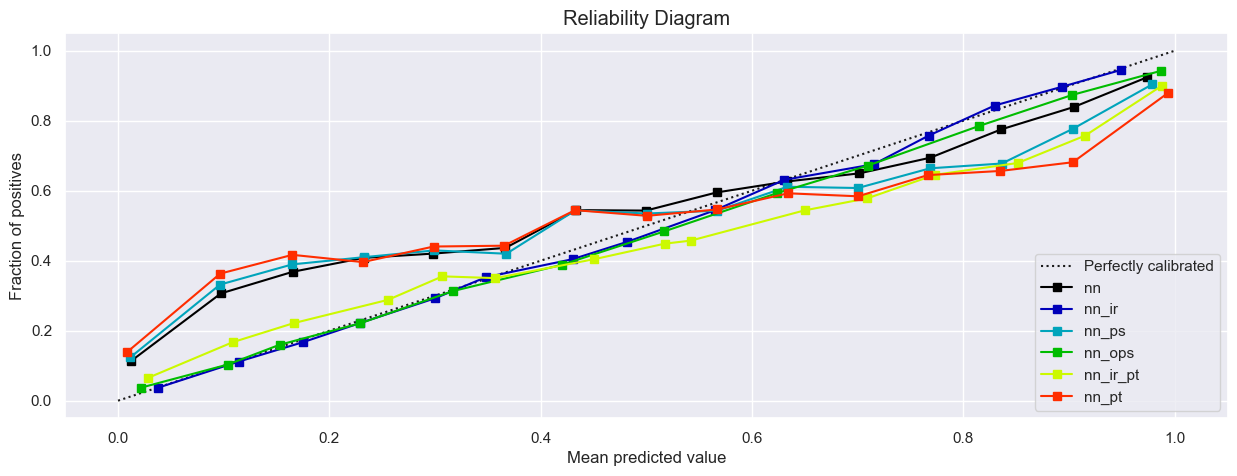

In [12]:
skplt.metrics.plot_calibration_curve(y_test, 
                                     probas_list=list(models_preds.values()), 
                                     clf_names=list(models_preds.keys()), 
                                     n_bins=15,
                                     title="Reliability Diagram")
plt.show()

Plot probability distribution of every nn model

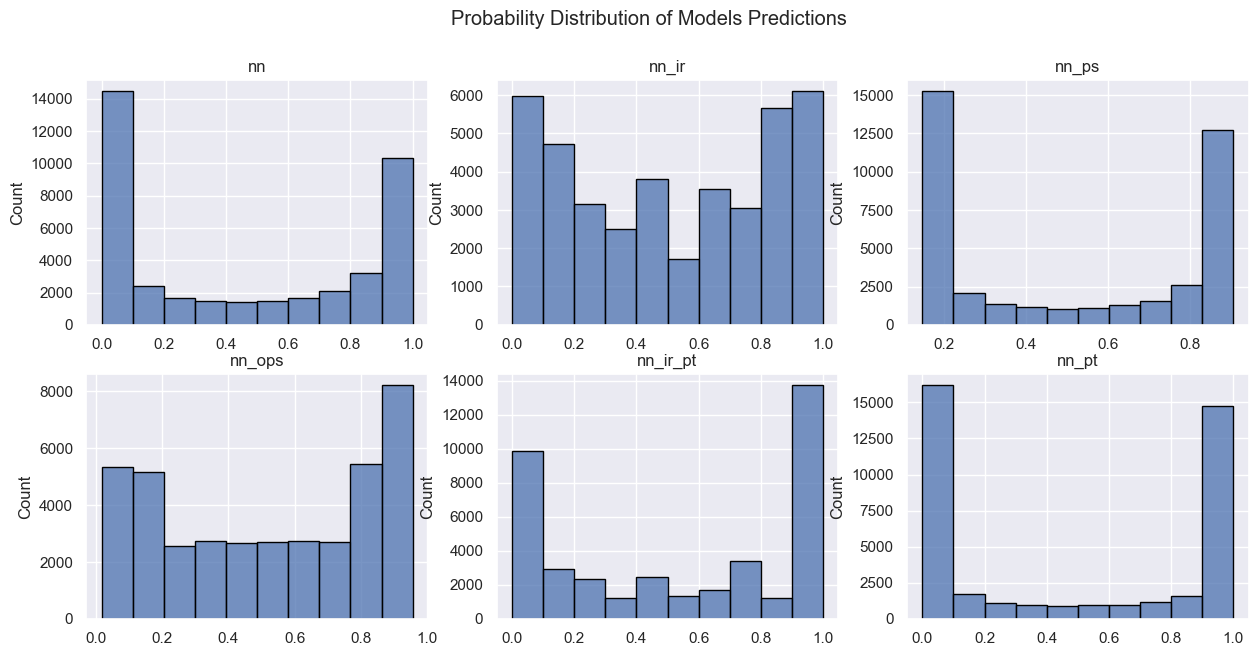

In [13]:
# plot seperate histogram of models predictions on the test set
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
for i, model_name in enumerate(models_preds.keys()):
    sns.histplot(models_preds[model_name], ax=axes[i], bins=10, edgecolor="black")
    axes[i].set_title(model_name)
plt.suptitle("Probability Distribution of Models Predictions")
plt.show()

plot model statistics on accuracy and calibration

In [14]:
# plot table of models statistics containing accuracy, f1-score, brier score ECE and MCE
stats = pd.DataFrame(columns=["accuracy", "f1-score", "NLL", "brier score", "ECE", "MCE", "OCE"])

for model_name in models_preds.keys():
    # calculate the statistics
    acc = accuracy_score(y_test, np.round(models_preds[model_name]))
    f1 = f1_score(y_test, np.round(models_preds[model_name]))
    nll = log_loss(y_test, models_preds[model_name])
    brier_score = brier_score_loss(y_test, models_preds[model_name])
    ece = expected_calibration_error(y_test, models_preds[model_name])
    mce = max_calibration_error(y_test, models_preds[model_name])
    oce = overconfidence_error(y_test, models_preds[model_name])

    # add the statistics to the table
    stats.loc[model_name] = [acc, f1, nll, brier_score, ece, mce, oce]

# Print the table
table = tabulate(stats, headers='keys', tablefmt='github')
print(table)

|          |   accuracy |   f1-score |      NLL |   brier score |        ECE |       MCE |         OCE |
|----------|------------|------------|----------|---------------|------------|-----------|-------------|
| nn       |   0.794679 |   0.787876 | 0.5448   |      0.153413 | 0.0888445  | 0.208983  | 0.00986276  |
| nn_ir    |   0.79724  |   0.796942 | 0.447345 |      0.142313 | 0.00774595 | 0.0269126 | 0.000130097 |
| nn_ps    |   0.796196 |   0.794154 | 0.459308 |      0.146689 | 0.0384596  | 0.115154  | 0.00239338  |
| nn_ops   |   0.793212 |   0.801376 | 0.442277 |      0.142469 | 0.00759279 | 0.0236259 | 0.000101328 |
| nn_ir_pt |   0.794132 |   0.800607 | 0.71327  |      0.149795 | 0.0697562  | 0.175971  | 0.00709051  |
| nn_pt    |   0.795773 |   0.792061 | 1.3725   |      0.165243 | 0.110361   | 0.256924  | 0.0179812   |
